In [1]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)

matplotlib.use("Agg")  # noqa: E402

In [2]:
from scipy.stats import lognorm

# Define parameters for the log-normal distribution
mean = 1.1567  # Mean of the distribution
sigma = 0.05  # Standard deviation of the logarithm of the distribution

# Create a log-normal distribution object
Theta_crit_prior = lognorm(s=sigma, scale=mean)
x = np.linspace(0.9, 2, 1000)
pdf = Theta_crit_prior.pdf(x)
plt.plot(x, pdf, 'r-', lw=2, label='PDF')

plt.title('Prior $\Theta_{{crit}}$ Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
##Read in the data sets needed. X_1 and X_2 are the training feature data for
##the GPs. Y_1 are the labels for the first GP regression (area estimates), Y_2 are the
##labels for the second GP regression (distance errors)
##########################
#Read in training data X_1, X_2
file_path = 'Ped_1_GP_Training_Data_Features_X.txt'

X_1 = np.loadtxt(file_path)
X_2 = X_1
#########################
#Read in training labels Y_1 for the Area Growth Values Ag for the 100 tests
file_path = 'Ped_1_GP_Training_Data_Labels_Y1.txt'

Y_1 = np.loadtxt(file_path)

##########################
#Read in training labels Y_2 for the Mean Distance Errors for the 100 tests
file_path = 'Ped_1_GP_Training_Data_Labels_Y2.txt'

# Read the data from the file
Y_2 = np.loadtxt(file_path)

#############################
#Read in test data X_Test (just a copy of the training features data for now)
file_path = 'Ped_1_GP_Testing_Data_Features_X.txt'

X_test = np.loadtxt(file_path)
#############################
#Read in test data results Y_Test_1 for the area growth Ag
file_path = 'Ped_1_GP_Testing_Data_Labels_Y1.txt'

Y_test_1 = np.loadtxt(file_path)
#############################
#Read in test data results Y_test_2 for the mean error
file_path = 'Ped_1_GP_Testing_Data_Labels_Y2.txt'

Y_test_2 = np.loadtxt(file_path)

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

kernel = C(1.0, (1e-3, 1e10)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Create a Gaussian Process Regressor object
gp_1 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Train the Gaussian Process Regressor
gp_1.fit(X_1, Y_1)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

[3298.3694338  2760.57314716 4806.01935593 2987.74759362 2677.71267887
 1711.60277485 1950.44300827 2038.56701023 2694.74783085 2362.32659035
 3637.08294222 4248.45607419 4806.89344898 1923.62835    2926.71316936
 3540.39306823 1877.03642191 3401.58983976 2075.89207531 1915.98453002
 3511.72162234 2696.65296848 2420.07321555 3764.90028171]


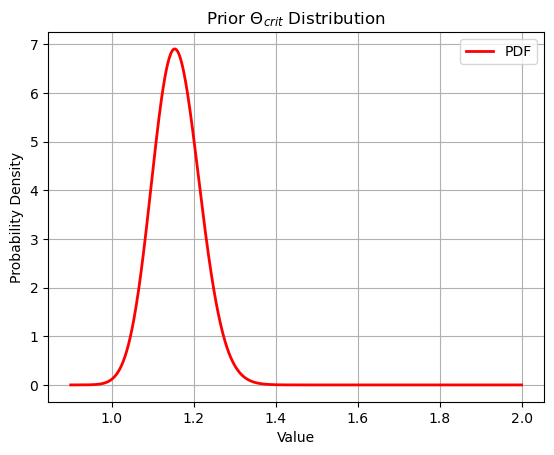

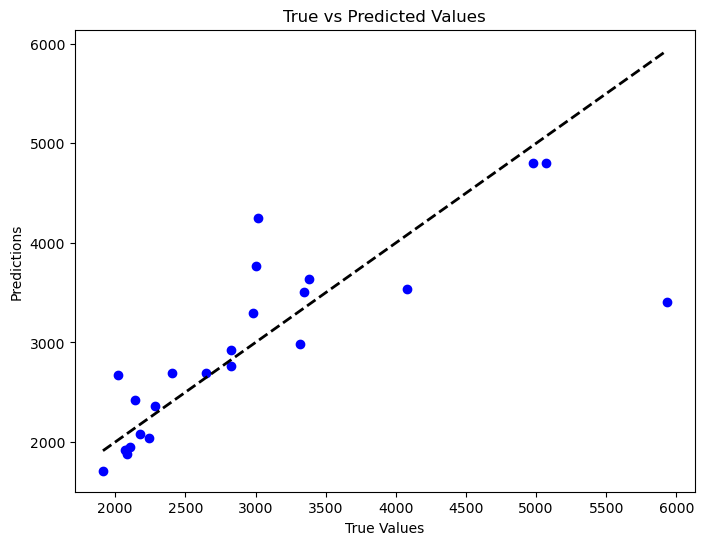

In [5]:
x_pred = X_test
#np.random.rand(100, 5)  # Generate new input data for prediction
y_pred, sigma = gp_1.predict(x_pred, return_std=True)
print(y_pred)
# Plot the results (since the output dimensionality is 1, it's difficult to visualize)
# Instead, you can plot the predicted values against the true values
plt.figure(figsize=(8, 6))
plt.scatter(Y_test_1, y_pred, color='blue')
plt.plot([Y_test_1.min(), Y_test_1.max()], [Y_test_1.min(), Y_test_1.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

mse = mean_squared_error(Y_test_1, y_pred)

# Compute the root mean squared error
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse} mm^2")

r_squared = r2_score(Y_test_1, y_pred)

print("R-squared (R²):", r_squared)

Root Mean Squared Error (RMSE): 645.667994325026 mm^2
R-squared (R²): 0.6269962802871673


In [7]:
# Create a Gaussian Process Regressor object
gp_2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Train the Gaussian Process Regressor
gp_2.fit(X_2, Y_2) #Train the GP on just tol, h, mu data

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

[1.77910751 1.77351433 1.75690871 1.75171108 1.92420991 1.83729216
 1.93183747 1.80449024 1.80555004 1.93389394 1.74110269 1.96448416
 1.72333285 1.95128477 1.89487164 1.88916596 1.86159952 1.99357769
 1.80265286 1.83153092 1.84161108 2.02979918 1.70346303 1.95000482]


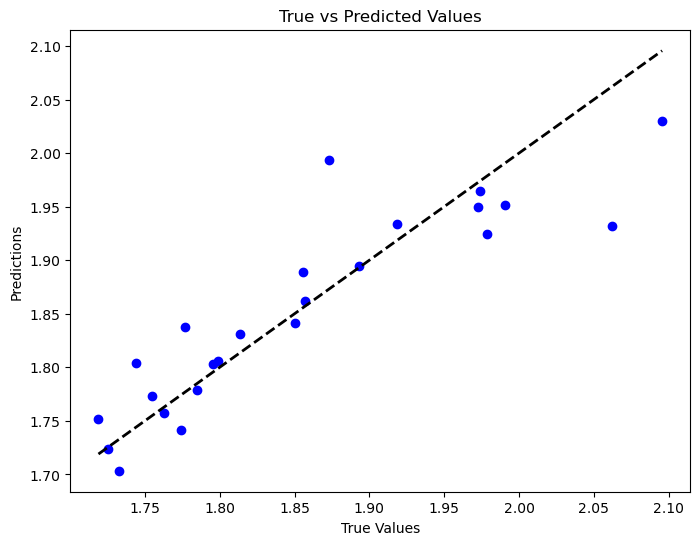

In [8]:
x_pred = X_test
#np.random.rand(100, 5)  # Generate new input data for prediction
y_pred_2, sigma = gp_2.predict(x_pred, return_std=True)
print(y_pred_2)
# Plot the results (since the output dimensionality is 1, it's difficult to visualize)
# Instead, you can plot the predicted values against the true values
plt.figure(figsize=(8, 6))
plt.scatter(Y_test_2, y_pred_2, color='blue')
plt.plot([Y_test_2.min(), Y_test_2.max()], [Y_test_2.min(), Y_test_2.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

In [9]:
mse = mean_squared_error(Y_test_2, y_pred_2)

# Compute the root mean squared error
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse} mm")

r_squared = r2_score(Y_test_2, y_pred_2)

print("R-squared (R²):", r_squared)

Root Mean Squared Error (RMSE): 0.04723544991659216 mm
R-squared (R²): 0.805313570519241


In [10]:
pip install emcee
pip install corner

SyntaxError: invalid syntax (3495118746.py, line 1)

In [ ]:
from sklearn.mixture import GaussianMixture
class CustomGMM:
    def __init__(self, n_components=1, **kwargs):
        self.gmm = GaussianMixture(n_components=n_components, **kwargs)

    def fit(self, X):
        self.gmm.fit(X)

    def pdf(self, X):

        return np.exp(self.gmm.score_samples(np.array(X).reshape(-1, 1)))

In [ ]:
## Fit a Gaussian Mixture to Tina's Distribution
from sklearn.mixture import GaussianMixture
from IPython.display import display
%matplotlib inline

with open("Tina_kk_distribution_day_inverse.txt", 'r') as file:
   lines = file.readlines()

data = []
for line in lines:
    # Assuming each line contains one data point
    data_point = float(line.strip())  # Convert string to float
    data.append(data_point)

# Convert the list to a NumPy array if needed
import numpy as np
data_array = np.array(data)

gmm_data = data_array.reshape(-1,1)

# Fit a Gaussian Mixture Model
gmm = CustomGMM(n_components=3, random_state=42)
gmm.fit(gmm_data)


#Fit a second GMM without using the custom class fix to sample from it directly
gmm_2 = GaussianMixture(n_components=3, random_state=42)
gmm_2.fit(gmm_data)

# Generate data points for plotting
x = np.linspace(0, 300, 1000000)
# Compute the log-density of the Gaussian mixture model at each point
density = gmm.pdf(x)

# Plot the data and the fitted Gaussian mixture model
plt.hist(data, bins=30, density=True, alpha=0.5, color='blue')

plt.plot(x, density, color='red', label='GMM')
plt.xlim([0,3])
plt.xlabel('Growth Rate k [day^-1]')
plt.ylabel('Density')
plt.title('#Fitting Mixed Gaussian Model to Data')
plt.legend()
plt.show()
plt.show()

kk_prior = gmm

In [ ]:
starting_k_samples, __ = gmm_2.sample(100)
starting_k_samples = starting_k_samples.flatten().tolist()
print(starting_k_samples)

In [ ]:
#Encodes the starting sample information for the walkers that sample on the k prior
plt.figure()
plt.hist(starting_k_samples, bins=30)
plt.xlim([0,3])

In [ ]:
print(np.random.uniform(1.1, 1.3, 100))

In [ ]:
hyperparameters = gp_1.kernel_.get_params()

# Print the length scale
print(hyperparameters)

hyperparameters_2 = gp_2.kernel_.get_params()

print(hyperparameters_2)

In [ ]:
gp_1._get_param_names()

In [ ]:
from scipy.stats import lognorm

# Define parameters for the log-normal distribution
mean = 1.1567  # Mean of the distribution
sigma = 0.05  # Standard deviation of the logarithm of the distribution

# Create a log-normal distribution object
Theta_crit_prior = lognorm(s=sigma, scale=mean)
x = np.linspace(0.9, 2, 1000)
pdf = Theta_crit_prior.pdf(x)
plt.plot(x, pdf, 'r-', lw=2, label='PDF')

plt.title('Prior $\Theta_{{crit}}$ Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#code to fix how the gmm pdf evaluates probability densities
def extract_first_item(obj):
    if isinstance(obj, np.ndarray) and obj.size > 0:
        return obj[0]
    else:
        return obj

In [ ]:

import warnings
import numpy as np
import emcee
import corner
# Filter out runtime warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Function to compute likelihood
def likelihood(X, y, f):
    ##sigma_1 = 645 #rms error for area gp
    #sigma_2 = 0.001 #rms error for distance gp
    sigma_2 = 0.526
    #sigma_1 = 2
    y_pred, err_pred = f(X)  # Predicted output from the function f
    # Assuming Gaussian likelihood
    #Sigma 2 likelihood = (1/(sigma_2*np.sqrt(2*np.pi)))*np.exp(-0.5 * np.sum(((err_pred)**2)/(sigma_2**2)))#*np.exp(-0.5*sigma_2**2)*(1/(sigma_2*np.sqrt(2*np.pi))),   # Likelihood function with just Error Prediction
    likelihood = (1/(sigma_2*np.sqrt(2*np.pi)))*np.exp(-0.5 * np.sum(((err_pred-1.2)**2)/(sigma_2**2))),   # Likelihood function

    return likelihood

# Function to compute log posterior
def log_posterior(X, y, f, prior_distributions):
    # Prior probabilities for each input variable in X
    prior_probs = [extract_first_item(prior.pdf(x)) for prior, x in zip(prior_distributions, X)]  # Exclude sigma_2

    # Compute the likelihood
    likelihood_val = likelihood(X, y, f)

    # Compute the log posterior
    log_posterior_val = np.sum(np.log(prior_probs)) + np.log(likelihood_val)

    return log_posterior_val
# Define your function f that maps inputs X to output y
def f(X):

    y_pred = gp_1.predict(X.reshape(1, -1))
    err_pred = gp_2.predict(X.reshape(1, -1))
    return y_pred, err_pred

from scipy.stats import uniform
from scipy.stats import norm

###### Define prior distributions for input variables in X
#tol_prior = uniform(loc=, scale=25 - 12)
#h_prior = uniform(loc=2, scale=12 - 2)
#mu_prior = uniform(loc=0.0, scale = 1.0 - 0.0)
#Theta_crit_prior = Theta_crit_prior
#kk_prior = kk_prior


tol_prior = uniform(loc=12, scale=25 - 12)
h_prior = uniform(loc=2, scale=12 - 2)
mu_prior = uniform(loc=0.0, scale = 1.0 - 0.0)
Theta_crit_prior = uniform(loc=0.9, scale=2.2-0.9)
kk_prior = kk_prior

prior_distributions = [tol_prior, h_prior, mu_prior, Theta_crit_prior, kk_prior]

# Define the measured output y
y_observed = 4018.853198 # measured area growth value

# Initialize MCMC sampler
nwalkers = 100  # Number of walkers
ndim = 5  # Dimensionality of the parameter space
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(y_observed, f, prior_distributions))

# Run MCMC sampling
nsteps = 10000  # Number of MCMC steps
# Generate random numbers for each column
column1 = np.random.uniform(12, 25, 100)
column2 = np.random.uniform(2, 12, 100)
column3 = np.random.uniform(0.0, 1.0, 100)
column4 = np.random.uniform(0.9, 2.2, 100)
column5 = starting_k_samples
# Stack the columns horizontally to create the array

array = np.column_stack((column1, column2, column3, column4, column5))

# Repeat the vector 100 times
initial_positions = array # Initial positions for walkers
step_count = 0

while step_count < nsteps:
    # Run MCMC for a subset of steps
    sampler.run_mcmc(initial_positions, nsteps=1000)


    # Increment step count
    step_count += 1000

    # You can perform any desired operations or monitoring here
    # Example: Print the current step count every 100 steps
    print(f"Completed {step_count} steps out of {nsteps}")

# Extract samples from the sampler
samples = sampler.chain[:, :, :].reshape((-1, ndim))

# Extract samples from the sampler
pair_plot_samples = sampler.get_chain(flat=True)

# Create a pair plot
fig = corner.corner(pair_plot_samples, labels=["tol", "h", "mu", "Theta_crit", "kk"],
                    truths=[None, None, None, None, None])

# Show the plot
plt.show()

In [ ]:
print(np.shape(samples))

In [ ]:
import matplotlib.pyplot as plt

# Extract samples for each input variable
posterior_tol = samples[:, 0]  # Samples for the first input variable
posterior_h = samples[:, 1]  # Samples for the second input variable
posterior_mu = samples[:, 2]  # Samples for the third input variable
posterior_theta_crit = samples[:, 3]  # Samples for the fourth input variable
posterior_kk = samples[:, 4]  # Samples for the fifth input variable
# Plot histograms of the samples

tol_uniform_samples = np.random.uniform(low=12, high=25, size=100000)
h_uniform_samples = np.random.uniform(low=2, high=12, size=100000)
mu_uniform_samples = np.random.uniform(low=0.0, high=1.0, size=100000)
#Theta_Crit_lognormal_samples = np.log(np.random.lognormal(mean=mean, sigma=sigma, size=100000))
Theta_Crit_lognormal_samples = np.random.uniform(low=0.9, high=2.2, size=100000)
sigma_2_samples = np.random.uniform(low=0.05, high=2, size=100000)

#Plot Tol Prior and Posterior Distributions
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(tol_uniform_samples, bins=30, density=True, color='blue', alpha=0.6, edgecolor='black')
axs[0].set_xlabel('Prior Tol Distribution [mm]')
axs[0].set_ylabel('Probability Density')
axs[0].set_xlim([12, 25])
axs[0].set_ylim([0, 1.25])

axs[1].hist(posterior_tol, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')
axs[1].set_xlabel('Posterior Tol Distribution after MCMC [mm]')
axs[1].set_ylabel('Probability Density')
axs[1].set_xlim([12, 25])
axs[1].set_ylim([0, 1.25])
plt.show()

#Plot h Prior and Posterior Distributions
fig2, axs2 = plt.subplots(1, 2, figsize=(10, 5))
axs2[0].hist(h_uniform_samples, bins=30, density=True, color='blue', alpha=0.6, edgecolor='black')
axs2[0].set_xlabel('Prior h Distribution [mm]')
axs2[0].set_ylabel('Probability Density')
axs2[0].set_xlim([2, 10])
axs2[0].set_ylim([0, 1])


axs2[1].hist(posterior_h, bins=30, density=True, alpha=0.6, color='r', edgecolor='black')
axs2[1].set_xlabel('Posterior h Distribution after MCMC [mm]')
axs2[1].set_ylabel('Probability Density')
axs2[1].set_xlim([2, 10])
axs2[1].set_ylim([0, 1])

#Plot mu Prior and Posterior Distributions
fig3, axs3 = plt.subplots(1, 2, figsize=(10, 5))
axs3[0].hist(mu_uniform_samples, bins=30, density=True, color='blue', alpha=0.6, edgecolor='black')
axs3[0].set_xlabel('Prior $mu$ Distribution [MPa]')
axs3[0].set_ylabel('Probability Density')
axs3[0].set_xlim([0, 1])
axs3[0].set_ylim([0, 8])

axs3[1].hist(posterior_mu, bins=30, density=True, alpha=0.6, color='g', edgecolor='black')
axs3[1].set_xlabel('Posterior $mu$ Distribution after MCMC [MPa]')
axs3[1].set_ylabel('Probability Density')
axs3[1].set_xlim([0, 1])
axs3[1].set_ylim([0, 8])

#Plot Theta Crit Prior and Posterior Distributions
fig4, axs4 = plt.subplots(1, 2, figsize=(10, 5))
axs4[0].hist(Theta_Crit_lognormal_samples, bins=30, density=True, color='blue', alpha=0.6, edgecolor='black')
axs4[0].set_xlabel('Prior $\Theta_{{crit}}$ Distribution')
axs4[0].set_ylabel('Probability Density')
axs4[0].set_xlim([0.9, 2.2])
axs4[0].set_ylim([0, 8])


axs4[1].hist(posterior_theta_crit, bins=30, density=True, alpha=0.6, color='y', edgecolor='black')
axs4[1].set_xlabel('Posterior $\Theta_{{crit}}$ Distribution after MCMC')
axs4[1].set_ylabel('Probability Density')
axs4[1].set_xlim([0.9, 2.2])
axs4[1].set_ylim([0, 8])
plt.show()


fig5, axs5 = plt.subplots(1, 2, figsize=(10, 5))
x = np.linspace(0, 3, 10000)
density = gmm.pdf(x)
axs5[0].hist(data, bins=30, density=True, alpha=0.5, color='blue')
axs5[0].plot(x, density, color='red', label='GMM')
axs5[0].set_xlim([0,3])
axs5[0].set_ylim([0, 2.25])
axs5[0].set_xlabel('Prior kk Distribution')
axs5[0].set_ylabel('Density')
axs5[0].legend()

axs5[1].hist(posterior_kk, bins=30, density=True, alpha=0.6, color='m', edgecolor='black')
axs5[1].set_xlim([0,3])
axs5[1].set_ylim([0, 2.25])
axs5[1].set_xlabel('Posterior kk Distribution after MCMC')
axs5[1].set_ylabel('Probability Density')

plt.show()



In [ ]:
import numpy as np
sigma_2 = 0.2

In [ ]:
(1/(sigma_2*np.sqrt(2*np.pi)))*np.exp(-0.5 * np.sum(((1)**2)/(sigma_2**2)))*np.exp(sigma_2**2)

In [ ]:
print(np.shape(samples))

In [ ]:
print(np.mean(samples[:,3]))